In [1]:
#pip install openpyxl

In [12]:
%matplotlib widget 
import pandas as pd
import numpy as np
import argopy
import xarray as xr
from pathlib import Path
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt

In [13]:
# Init
rep_data_argo = '/Volumes/ref-argo/gdac/dac/coriolis/'
i_test = 3
if i_test==1:
    file_path = "liste_float_lops.xlsx"  
    sheet_name = "Deep LOPS floats"  
    # Lecture de la premiere colonne
    df = pd.read_excel(file_path, sheet_name=sheet_name, usecols=[0], header=None)
    df.columns = ["WMO"]
elif i_test==2:
    file_path = 'liste_floats_coriolis_doxy_2000m_uniq.txt'
    df = pd.read_csv(file_path)
else:
    file_path = 'liste_floats_coriolis_doxy_deep_uniq.txt'
    #file_path = 'liste_floats_6902807.txt'
    df = pd.read_csv(file_path)

print(f'Travail sur le fichier {file_path}')

valeurs = df["WMO"].dropna() 


Travail sur le fichier liste_floats_6902807.txt


In [14]:
valeurs

0    6902807
Name: WMO, dtype: int64

In [15]:
# Définir une grille de pression commune (de min à max avec 50 points)
common_pres_surf_fond = np.arange(0, 7000, 50)
common_pres_1000_fond = np.arange(1000, 7000, 50)


cycle_differences_surf_fond = []
cycle_differences_1000_fond = []
num_cycle_differences = []
float_difference = []
nb_float = 0
for v in valeurs:
    try:
        #print(f"traitement du flotteur : {float(v)}")  
        p = Path(rep_data_argo)
        nom_file = p.joinpath(str(v)).joinpath(str(v) + '_Sprof.nc')
        ds = xr.open_dataset(nom_file,engine='argo')
        nb_float = nb_float + 1
        direction = ds["DIRECTION"].values
        cycle_numbers = ds["CYCLE_NUMBER"].values
        mask0 = cycle_numbers==0
        #if len(cycle_numbers[mask0])>0:
        #    print(f'{v} a un cycle 0')
                  
        pressure = ds["PRES"].values  # (cycles, niveaux de pression)
        doxy = ds["DOXY"].values
        doxy_qc = ds["DOXY_QC"].values  # Qualité des mesures
        doxy = np.where(doxy_qc.astype(str) != "4", doxy, np.nan)
        # Interpoler chaque profil DOXY sur cette grille de pression
        interpolated_doxy_surf_fond = []
        interpolated_doxy_1000_fond = []
        cycle_list = []
        for i in range(len(cycle_numbers)):
            if direction[i]=='A':
                cycle_list.append(cycle_numbers[i])
                valid_mask = ~np.isnan(pressure[i]) & ~np.isnan(doxy[i])  # Points valides
                if np.sum(valid_mask) > 2:  # Vérifie qu'on a assez de points valides
#                interp_func = interp1d(pressure[i][valid_mask], doxy[i][valid_mask], 
#                               kind="linear", bounds_error=False, fill_value=np.nan)
#                interpolated_doxy.append(interp_func(common_pres))

                    val_bid = np.interp(common_pres_surf_fond,pressure[i][valid_mask],doxy[i][valid_mask],left=np.nan,right=np.nan)
                    interpolated_doxy_surf_fond.append(val_bid)
                    
                    val_bid = np.interp(common_pres_1000_fond,pressure[i][valid_mask],doxy[i][valid_mask],left=np.nan,right=np.nan)
                    interpolated_doxy_1000_fond.append(val_bid)
                else:
                    interpolated_doxy_surf_fond.append(np.full_like(common_pres_surf_fond, np.nan,dtype=np.double))
                    interpolated_doxy_1000_fond.append(np.full_like(common_pres_1000_fond, np.nan,dtype=np.double))

        interpolated_doxy_surf_fond = np.array(interpolated_doxy_surf_fond)  # Convertir en tableau NumPy
        interpolated_doxy_1000_fond = np.array(interpolated_doxy_1000_fond)  # Convertir en tableau NumPy
            
        for i in range(1, len(cycle_list)):
            if cycle_list[i-1] == cycle_list[i]-1: # On s'assure que les cycles sont consecutifs (cf. flotteur 6901468)
                diff = np.nanmean(interpolated_doxy_surf_fond[i] - interpolated_doxy_surf_fond[i-1])
                cycle_differences_surf_fond.append(diff) 
                diff = np.nanmean(interpolated_doxy_1000_fond[i] - interpolated_doxy_1000_fond[i-1])
                cycle_differences_1000_fond.append(diff) 
                num_cycle_differences.append(cycle_list[i])
                float_difference.append(v)
            else:
                print(f"{v} : cycles non consecutifs : {cycle_list[i-1]} suivi de {cycle_list[i]}")
                

    except:
        print(f'souci : {v}')
        None


In [16]:
nb_float

1

In [17]:
#plt.figure()
#plt.plot(pressure[len(cycle_numbers)-1],doxy[len(cycle_numbers)-1],'*-')
#plt.plot(common_pres_1000_fond,val_bid,'or-')

In [18]:
num_cycle_differences = np.array(num_cycle_differences)
cycle_differences_surf_fond = np.array(cycle_differences_surf_fond)
cycle_differences_1000_fond = np.array(cycle_differences_1000_fond)

mean_diff_surf_fond = []
mean_diff_1000_fond = []
num_cycle_for_mean = []

for i in range(1,np.max(num_cycle_differences)+1):
    valid_mask = num_cycle_differences == i
    mean_diff_surf_fond.append(np.nanmedian(cycle_differences_surf_fond[valid_mask]))
    mean_diff_1000_fond.append(np.nanmedian(cycle_differences_1000_fond[valid_mask]))
    num_cycle_for_mean.append(i)

In [19]:
#plt.figure()
#plt.plot(num_cycle_differences,'*-')
#isok = num_cycle_differences==2
#print(len(num_cycle_differences[isok]))
#print(nb_float)

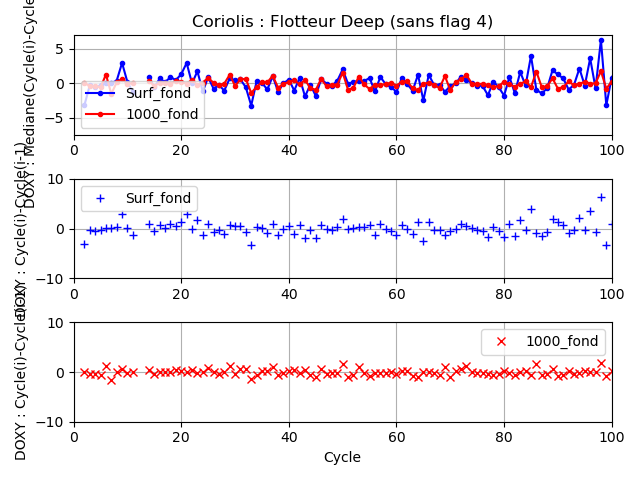

In [22]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(num_cycle_for_mean,mean_diff_surf_fond,'.-b',label='Surf_fond')
plt.plot(num_cycle_for_mean,mean_diff_1000_fond,'.-r',label='1000_fond')
plt.grid()
plt.ylabel('DOXY : Mediane(Cycle(i)-Cycle(i-1))')
plt.legend(draggable=True)
plt.title('Coriolis : Flotteur Deep (sans flag 4)')
#plt.ylim([-3,3])
plt.xlim([0,100])
plt.subplot(3,1,2)
plt.plot(num_cycle_differences,cycle_differences_surf_fond,'+b',label='Surf_fond')
plt.grid()
plt.ylim([-10,10])
plt.xlim([0,100])
plt.ylabel('DOXY : Cycle(i)-Cycle(i-1)')
plt.legend()
plt.subplot(3,1,3)
plt.plot(num_cycle_differences,cycle_differences_1000_fond,'xr',label='1000_fond')
plt.grid()
plt.ylabel('DOXY : Cycle(i)-Cycle(i-1)')
plt.ylim([-10,10])
plt.xlim([0,100])
plt.legend()
plt.xlabel('Cycle')
plt.tight_layout()

In [10]:
nb_float

132

In [48]:
mask = num_cycle_differences==1000
len(num_cycle_differences[mask])

0

In [47]:
cycle_list[0:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]